# Calculating unbinding free energy and mean first passage time using milestoning

In this notebook I will walk oyu through:<br/>
1. Project metadynamics trajectories into PCs (review Milestoning_Generate.ipynb)
2. Use the previously milestones, and project short MD trajectories into PCs.
3. Construct transition kernel matrix (this is the heart of the milestoning theory)
4. Generate potential of mean force profile along milestones, and calculate $\Delta G$
5. Calculate mean first passage time 
6. Collect initial-point distribution (IPD) and first hitting point distribution (FHPD) on the milestone
7. Extract representative frames of the milestones.

In [1]:
import sys
sys.path.append('./modules/')
sys.path.insert(1,'/hdd/si_han/cpptraj_test/pytraj')

import pytraj as pt
from sklearn.decomposition import PCA
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from interpolateCurve import interpolateCurve
from log_progress import*
from Project import*
from CorrectXYnp import*
from RotationMatrix import*

# 1. Obtaining milestones from biased MD or PSIM (optional)
This section is repeating Milestoning_Generate.ipynb, and you might skip it if you want (although it's relatively cheap step, and it helps you to make sure that everything is right before other steps). It depends on you. However, do remember to modify all the pathes and parameters in 1.1, which will be used to other sections.

## 1.1 Load metadynamics/PSIM trajectories to the notebook
In order to project high dimensional trajectories into low dimensional spaces, we start by loading the Cartesian coordinates of protein and ligand using **pytraj**.

In [2]:
# specify path of promtop and dcd files
reaction_path = '/hdd/si_han/Project/CDK8/metadynamics/WeiChen_VM2_candidates/002_C301-8809/100ns_seed6_restrt/'
TOP = '/hdd/si_han/Project/CDK8/MD/WeiChen_VM2_candidates/002_C301-8809/00.prep/06_tleap/GB.prmtop'
TRAJ = reaction_path+'/nowater_combined.dcd'
PDB = '/hdd/si_han/GPU0/sh_tzy/CDK8/milestoning/metadynamics/CDK8_Cyclin_Ligand2/new/0.pdb'
mask = '(:1-359)&(@N,@C,@CA,@O)' # atoms used for alignment, change this according to your system
pca_sel_rule = ['@CA,:620', '!@H*'] # atoms used in PCA
milestone_path = reaction_path+'/Milestone_0' # path of the folder containing a milestone_slopes_*.npy file created by Milestoning_Generate.ipynb
projection_path = milestone_path+'/projections' # path of the folder containing PCA1.npy and PCA2.npy created by Project2PCA.py
T = 1000 # number of frames of each short MD simulation

##  Load metadynamics/PSIM trajectories and align to a reference structure
We next remove rotation and translation of the protein by aligning the protein to a reference frame. We used atomic masks to specify atoms used for alignment. The system for this tutorial is a CDK8/CycC-Ligand, where residues 1-359 is CDK8, residues 360-619 is Cyclin C, and residue 620 is the ligand (resname MOL).

In this case, we used all the backbone atoms of the CDK8 protein (residues 1-359) to perform alignment. 

In [3]:
# read the trajecory from the disk
traj = pt.iterload(TRAJ, TOP)
refpdb = pt.iterload(PDB)
pt.superpose(traj, ref=refpdb, mask=mask)

pytraj.TrajectoryIterator, 5604 frames: 
Size: 1.295180 (GB)
<Topology: 10340 atoms, 620 residues, 3 mols, non-PBC>
           

## 1.3 Reading trajectories ...
Now we need to extract the Cartesian coordinates from the trajectory, which will be used as high-d representations of the trajectory. Here, the selected Cartesian coordiates include all the alphe carbon atoms of proteins and all the heavy atoms of the ligand.  

In [4]:
# read the trajectory into memory by chunk
nframe = traj.n_frames
chunksize = min([200, nframe])
nchunk = int(np.floor(nframe/chunksize))+1 if nframe%chunksize !=0 else int(np.floor(nframe/chunksize))
pile = []
for i in log_progress(range(nchunk), every=1):
    tmp = traj[i*chunksize:min((i+1)*chunksize, nframe)][pca_sel_rule[0]][pca_sel_rule[1]]
    pile.append(tmp.xyz.reshape(tmp.n_frames, tmp.n_atoms*3))

proteinUNK_2d = np.concatenate(pile,axis=0)[:4700]

## 1.4 Prepare cartesian cordinate matrix, covariance matrix for PCA

In [5]:
# PCA using sklearn
pca = PCA(n_components=2)
reduced_cartesian = pca.fit_transform(proteinUNK_2d)
print(reduced_cartesian.shape)

# obtain eigvals and eigvecs
eigvals = pca.explained_variance_ratio_
eigvecs = pca.components_.T

(4700, 2)


## 1.5 Visualize PCAs

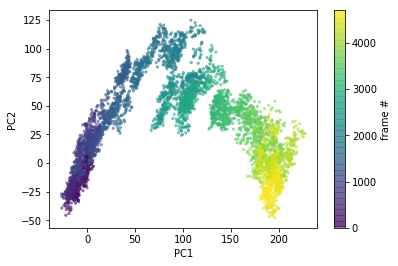

In [6]:
# set the first frame of the trajectory as an origin
refframe =  proteinUNK_2d[0,:].copy()
proteinUNK_ref_2d = proteinUNK_2d - refframe

# project high-d Cartesian coordinates into low-d PCs
projections=np.concatenate((np.dot(proteinUNK_ref_2d, eigvecs[:,0]).reshape(len(proteinUNK_ref_2d),1),
                            np.dot(proteinUNK_ref_2d, eigvecs[:,1]).reshape(len(proteinUNK_ref_2d),1)),
                           axis=1)
# plot results
plt.figure()
plt.scatter(projections[:,0],projections[:,1],
        marker='o', s = 5,
        c=range(int(len(proteinUNK_2d))),
        alpha=0.5
        )
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('frame #')

## 1.6 Load Previously Constructed Milestones

### load centers of milestones

In [7]:
path = pd.read_csv(milestone_path+'/finalpath.txt', header=None, delimiter=r"\s+") # provide a file name of milesstone coordinates
fp = np.asarray(path)
fp = fp[:,1:3]
fp.shape

(200, 2)

#### assign spacing btw milestones

In [8]:
width = 4
id_ = np.arange(0,len(fp))
x_ = fp[:,0]
y_ = fp[:,1]

dw=1000
for i in range(10,281):
    fp_new = np.zeros([i,2])
    fp_new[:,0] = np.interp(np.linspace(0,len(fp)-1, i), id_, x_)
    fp_new[:,1] = np.interp(np.linspace(0,len(fp)-1, i), id_, y_)
    width_test = np.linalg.norm(fp_new[0]-fp_new[1])
    
    dw2 = abs(width - width_test)
    if dw2 < dw:
        dw = dw2
        num_M = i
        width_tmp = width_test
        fp_tmp = fp_new

print("%d milestones, width = %f"%(num_M, width_tmp))
fp = fp_tmp

114 milestones, width = 4.000963


### load slopes of milestones

In [9]:
slope_opt = np.load(milestone_path+'/milestone_slopes.npy') # provide a correct file name of milestone slopes
slope_opt.shape

(114, 1)

### To collect transition between milestone, we first add additional milestones at the front and the end of the original milestone set

In [10]:
fp_head = fp[0] + (fp[0]-fp[1])
fp_tail = fp[-1] + (fp[-1]-fp[-2])
fp_mod = np.append(fp_head.reshape(1,2), fp, axis=0)
fp_mod = np.append(fp_mod, fp_tail.reshape(1,2), axis=0)
fp_mod.shape

(116, 2)

In [11]:
slope_mod = np.append(slope_opt[0], slope_opt)
slope_mod = np.append(slope_mod, slope_opt[-1])
slope_mod = slope_mod.reshape(len(slope_mod),1)
slope_mod.shape

(116, 1)

### rebuild optimized milestones

In [12]:
# radiaus = sc/2
sc = 20 

# coordinates of milestones on the path
X = fp_mod[:,0].reshape(len(fp_mod),1)
Y = fp_mod[:,1].reshape(len(fp_mod),1)

# slope matrix NxN
M = np.zeros((len(slope_mod),len(slope_mod)))
np.fill_diagonal(M,slope_mod)

# boundary of milestones in x-axis Nx1
dX = np.sqrt((sc/2)**2/(1+slope_mod**2)).reshape(len(fp_mod),1)
Xp = X + dX
Xn = X - dX

# boundary of milestones in y-axis Nx1
Yp = Y + np.dot(M,dX)
Yn = Y - np.dot(M,dX)
CorrectXYnp(Xp,Yp,Xn,Yn, slope_mod)

### Visualize previously built milestones

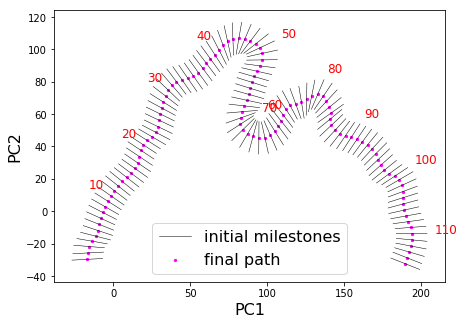

In [13]:
plt.figure(figsize=(7,5))
plt.scatter(X, Y, c='magenta',s=5, label='final path')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.legend(fontsize=16)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.tick_params()
plt.show()

# 2. Project short MD trajectories to PC1/PC2 space

## 2.1: Use the provided Project2PCA.py script to generate projections of short MD trajectories
Please use Project2PCA.py to generate projections.

## 2.2: Load generated projections

In [14]:
pca1, pca2 = [projection_path+'/PCA1.npy',
                   projection_path+'/PCA2.npy'
                  ]

PCA1 = np.load(pca1)
PCA2 = np.load(pca2)

#### visualize the projections in PC1/PC2 space

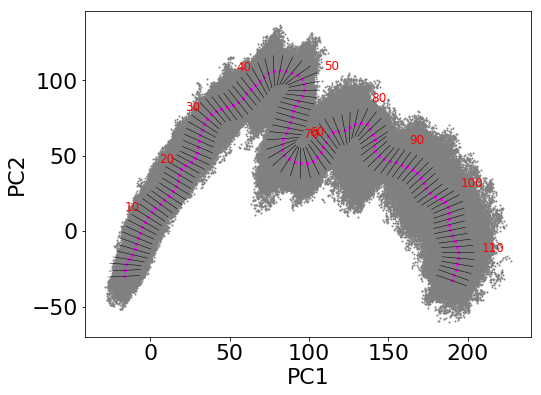

In [17]:
spacing=10

plt.figure(figsize=(8,6))
plt.plot(PCA1[::spacing], PCA2[::spacing],
         color = 'gray', marker='o', 
         markersize=1, linestyle='None', zorder=0)

plt.scatter(X, Y, c='magenta',s=5, zorder=1)

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='initial milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=12, color='r'))
plt.tick_params(labelsize=22)
plt.xlabel('PC1', fontsize=22)
plt.ylabel('PC2', fontsize=22)
plt.show()

## 2.3 Sort short MD frames into different milestone cells

#### run index search and save cell index of each frame

In [18]:
from SortByMilestones import *
MIDX = SortByMilestones(Xp, Xn, Yp, Yn, PCA1, PCA2)
MIDX.shape

(10280000,)

#### save cell index of each frame

In [19]:
# np.save(milestone_path+'/MIDX.npy', MIDX)

#### load cell index

In [19]:
MIDX = np.load(milestone_path+'/MIDX.npy')
MIDX.shape

(10280000,)

## 2.4 define color of each cell index
For better visulization, we assign different colors to projected frames in neighboring cells

In [20]:
# Assign color to each milestone cell
csel = ['pink','cyan','magenta','lawngreen']
color = []
color_tmp = np.array(['']*len(MIDX), dtype=(np.unicode_,10))
for j in range(len(csel)):
    color_tmp[MIDX%4 == j] = csel[j]
color_tmp[MIDX==2*len(X)] = 'gray'
color.append(color_tmp)   

## 2.5 Visualize cell distributions

/home/si_han/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


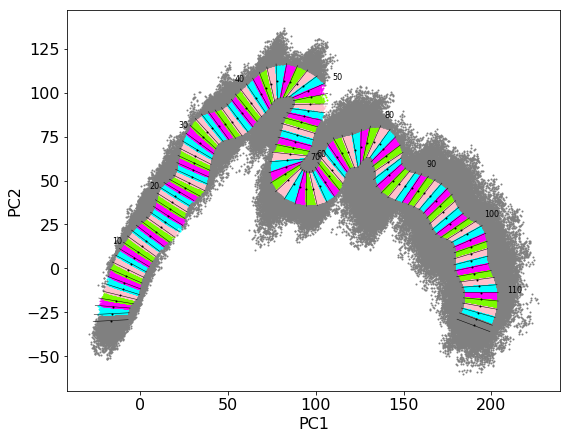

In [21]:
# for i in range(100):
#     %matplotlib notebook
%matplotlib inline

H = [] # H(x): numer of frames in each milestone

Fig=plt.figure(figsize=(14,7))

space = 10

for i in range(len(X)-1):
    index = np.where(MIDX==i)
    H.append([i, index[0].shape[0]])
    if len(index[0])!=0:
        if (i != 0) and (i!= len(X)-2):
            color_ = color[0][index[0][0]]
        else:
            color_ = 'gray'
        
        plt.plot(PCA1[index][0:-1:space],
                PCA2[index][0:-1:space],
                color = color_,
                marker='o', markersize=1,
                linestyle='None')

# project frames move beyond milestone lines
index = np.where(MIDX==2*len(X))
H.append([-1, index[0].shape[0]])
if len(index[0])!=0:
    plt.plot(PCA1[index][0:-1:space],
            PCA2[index][0:-1:space],
            color = color[0][index[0][0]],
            marker='o', markersize=1,
            linestyle='None')

plt.xlabel('PC1',fontsize=16)
plt.ylabel('PC2',fontsize=16)

plt.plot(X, Y, color='k', marker='o', markersize=1, linestyle='None')

for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
        if i%10==0:
            plt.annotate(i, (1.5*(Xn[i]-X[i])+X[i],1.5*(Yn[i]-Y[i])+Y[i]),
                        **dict(size=8, color='k'))  

plt.tick_params(labelsize=16)
plt.axes().set_aspect('equal')
plt.show()

## 2.6 Number of frames in each milestone cell

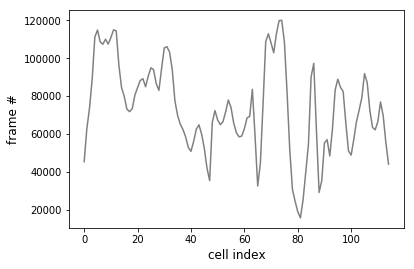

In [22]:
%matplotlib inline

plt.figure()
H = np.asarray(H)
recover = (1-H[-1][1]/len(PCA1))
plt.plot(H[:-1,0],H[:-1,1], color='gray')
plt.xlabel('cell index', fontsize=12)
plt.ylabel('frame #', fontsize=12)
plt.show()

# 3. Calculating dissociation free energy and MFPT

## 3.1 Collect transitions between milestones

### compute transitions of initial-points,  defined using "hit by crossing" and "hit by touching"

Transitions will be recorded in an array, TRANS, with the following columns:

[ NRUN, initial milestone, final milestone, initial frame, final frame, type ]

NRUN: index of the short MD run including the transition <br/>
initial milestone: index of the milestone of the initial point<br/>
final milestone: index of the terminating milestone of the transition<br/>
initial frame: starting frame number of the transition in the short MD simulation<br/>
final frame: terminating frame number of the transition in the short MD simulation<br/>
type: 0: crossing, 1: touching

In [23]:
from TransitionKernel import *

In [24]:
TRANS = TransitionKernel(PCA1, PCA2, MIDX, 
                         slope_mod, fp_mod, 
                         X, Y, sc, T, 
                         check_escape=True
                        )

total transition: 139756


### visualize transitions between milestones
The PlotTransitoin module will plot a transition you selected by assing 0 $\leq$ trans_id $<$ (total number of transition). The trancision will be shown in gradient color, from purple (intial) to yello (final), and the entire short MD simulation contiaing the transition segement is shown in gray.

In [25]:
from PlotTransition import *

Short MD ID:	6353
Initial frame:	294
Final frame:	303


<IPython.core.display.Javascript object>


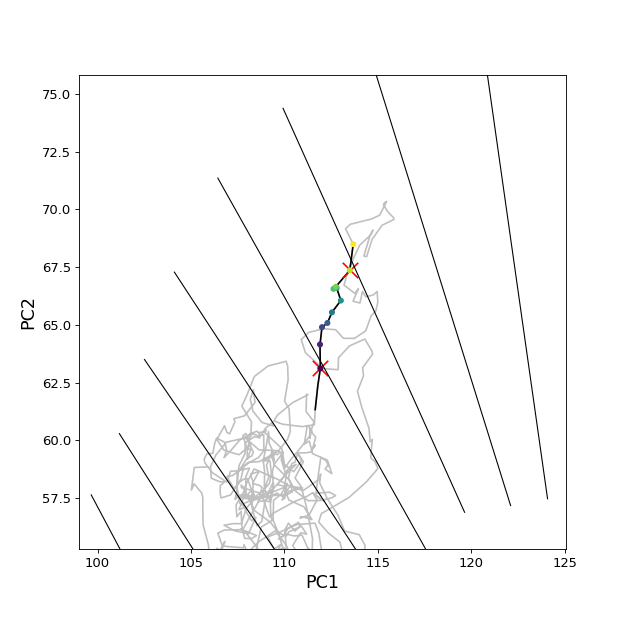

In [29]:
for i in range(100):
    %matplotlib notebook
    
PlotTransition(TRANS, PCA1, PCA2, 
               Xn, Xp, Yn, Yp, 
               T, sc, 
               trans_id=100000
               )

## 3.2 Construct transition kernel, $K$, and average lifetime of each milestone

In [30]:
kmat = np.zeros((len(fp_mod),len(fp_mod)))
mfpt = [ [] for i in range(len(fp_mod)) ]

for i in log_progress(range(len(TRANS)),every=50000):
    m_ini, m_f = [TRANS[i,1],TRANS[i,2]]
    nfr = TRANS[i,-2] - TRANS[i,-3]
    kmat[m_ini,m_f]+=1
    mfpt[m_ini].append(nfr)

kmat2=kmat[1:-1,1:-1].copy()
kmat2 = (kmat2.T/kmat2.sum(axis=1)).T
KMAT = kmat2

mfpt2 = []
for i in range(len(mfpt)):
    tmp = np.array(mfpt[i])
    if len(tmp) !=0:
        mfpt2.append([i,tmp.mean()*0.1,tmp.std()*0.1])
mfpt2=np.array(mfpt2)
MFPT = mfpt
MFPT_AVE = mfpt2

### visualize numbers of frames in milestone cells (left), and compare with transitions on the milestones (right)

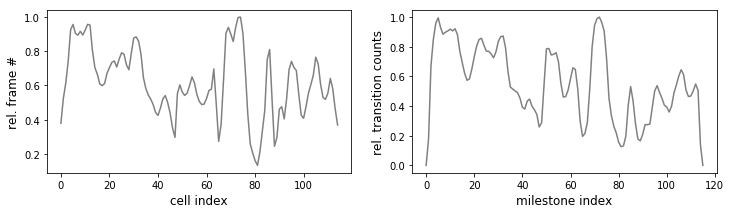

In [38]:
%matplotlib inline

plt.figure(figsize=(12,3))

plt.subplot(1,2,1)
recover = (1-H[-1][1]/len(MIDX))
H = np.asanyarray(H)
plt.plot(H[:-1,0],H[:-1,1]/H[:-1,1].max(), color='gray')
plt.xlabel('cell index', fontsize=12)
plt.ylabel('rel. frame #', fontsize=12)

plt.subplot(1,2,2)
y = np.array([len(MFPT[i]) for i in range(len(MFPT))])
plt.plot(range(len(MFPT)),y/y.max(),
        color='gray')
 
plt.xlabel('milestone index', fontsize=12)
plt.ylabel('rel. transition counts', fontsize=12)
plt.show()

### check trnasition kernel elements, $K_{j, j+1}$ and $K_{j-1, j}$ 

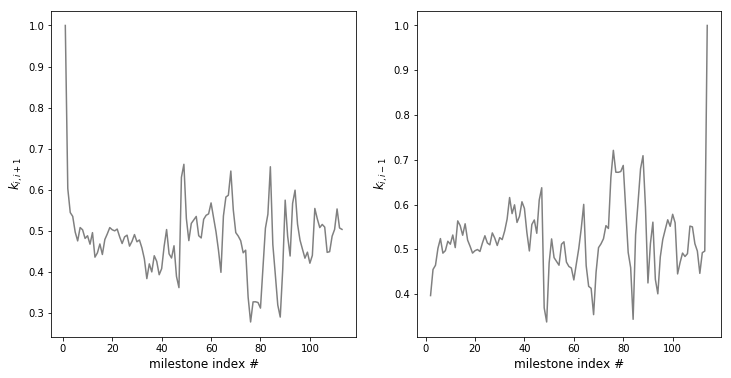

In [39]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
x = MFPT_AVE[:-1,0]
y = np.array([ KMAT[i,i+1] for i in range(len(KMAT)-1)])
plt.plot(x,y,color='gray')   
plt.xlabel('milestone index #', fontsize=12)
plt.ylabel('$k_{i,i+1}$', fontsize=12)

plt.subplot(1,2,2)
x = MFPT_AVE[1:,0]
y = np.array([ KMAT[i,i-1] for i in range(1,len(KMAT))])
plt.plot(x,y,color='gray')     
plt.xlabel('milestone index #', fontsize=12)
plt.ylabel('$k_{i,i-1}$', fontsize=12)

plt.show()

# 4. Calculation of dissociation free energy

## 4.1 set reflective boundary on the final milestone

In [40]:
# Define indices of initial and last milestones
b, f = 0, len(MFPT_AVE)-1

# Provide appropriative boundary condition to the last milestone
tmp = KMAT.copy()
tmp[f,f-1]=1
tmp[f,b]=0
tmp[b,b+1]=1
kernelsel = tmp
kernelsel = kernelsel[b:f+1,b:f+1]

## 4.2 Solve for stationary flux, q using both eigenvalue sover and power iteration

In [41]:
# eigenvalue method
evals, evecs = np.linalg.eig(kernelsel.T)
index = np.flipud(np.argsort(evals))
check=sum(1 for x in evecs[:,index[0]] if x < 0)
if check != 0 and check != len(index):
    print("i = %d Check Eigenvectors" %i)
    
q_eigen = evecs[:,index[0]]
PMF_eigen = -8.314*298/4184.0*np.log(np.abs(evecs[:f+1,index[0]])*MFPT_AVE[:f+1,1])
STD = 8.314*298/4184.0*MFPT_AVE[:,2]/MFPT_AVE[:,1]

# power iteration method
q = np.random.rand(len(fp))
for j in log_progress(range(100000),every=5000):
    q = np.dot(q, kernelsel)
    q /= np.linalg.norm(q)
q_power = q
PMF_power = -8.314*298/4184.0*np.log(np.abs(q_power[:f+1])*MFPT_AVE[:f+1,1])

## 4.3 Compare q obtained from both methods

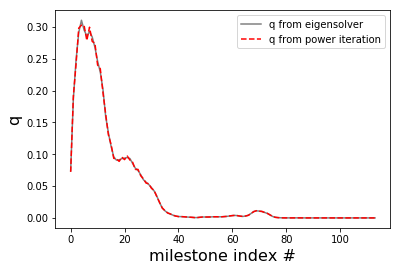

In [42]:
fig=plt.figure()
plt.plot( range(len(q_eigen)), abs(q_eigen), color='gray', label='q from eigensolver')
plt.plot( range(len(q_power)), q_power, '--',color='r', label='q from power iteration')
plt.legend()    
plt.xlabel('milestone index #', fontsize=16)
plt.ylabel('q', fontsize=16)
plt.show()

## 4.4 Visualize the potential of mean force (PMF) profile

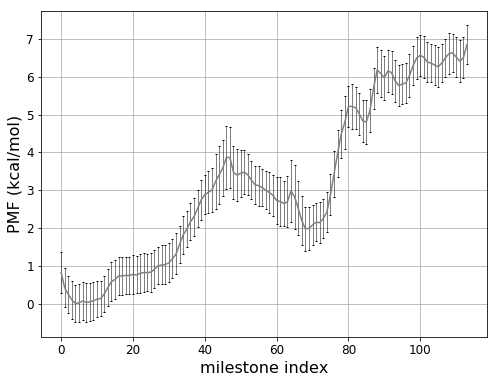

In [43]:
plt.figure(figsize=(8,6))

plt.errorbar(range(b, f+1), (PMF_eigen - PMF_eigen.min()), 
        STD, color='gray', ecolor='k', elinewidth=0.5, capsize=1
        )

plt.grid()
plt.xlabel('milestone index',fontsize=16)
plt.ylabel('PMF (kcal/mol)', fontsize=16)
plt.xticks(np.arange(b,(f+1), step=20))
plt.tick_params(labelsize=12)
plt.show()

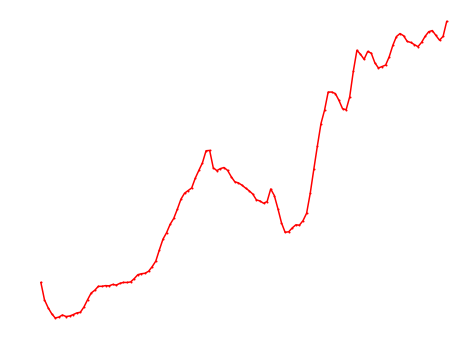

In [61]:
%matplotlib inline

fig = plt.figure(figsize=(8,6))

plt.plot( range(len(PMF_eigen)), (PMF_eigen - PMF_eigen.min()), 
         color='r' , marker='o', markersize=1)

plt.axis('off')
plt.show()
# fig.savefig('/home/si_han/Desktop/uf/WeiChen/002_pmf.png', transparent=True)

## 4.5 calculate unbinding free energy, $\Delta G$

In [44]:
b_, f_ = np.argmin(PMF_eigen), np.argmax(PMF_eigen)
print("Free energy between milestones %s and %s:"%(b_, f_))

DeltaG = -(PMF_eigen[f_] - PMF_eigen[b_])
stdG = np.sqrt(STD[b_]**2 + STD[f_]**2)
print("\u0394G =\t", DeltaG, "kcal/mol")
print("std =\t",  stdG, "kcal/mol" )

Free energy between milestones 4 and 113:
ΔG =	 -6.845760332516181 kcal/mol
std =	 0.7045818367202842 kcal/mol


# 5. Calculation of MFPT

## 5.1 set cyclic boundary on the final milestone
The modified trnasition kernel is deneted as $K^c$

In [45]:
kernelsel2=[]
b = b_
f = 100#f_ 
tmp = KMAT.copy()
tmp[b,b+1]=1
tmp[f,f-1]=0
tmp[f,b]=1 
kernelsel2 = tmp
kernelsel2 = kernelsel2[b:f+1,b:f+1]

## 5.2 Solve for stationary flux, q using eigenvalue sover 

In [46]:
evals, evecs = np.linalg.eig(kernelsel2.T)
index = np.flipud(np.argsort(evals))
check=sum(1 for x in evecs[:,index[0]] if x < 0)
if check != 0 and check != len(index):
    print("i = %d Check Eigenvectors" %i)

q_mfpt = evecs[:,index[0]]
PMF_mfpt = -8.314*298/4184.0*np.log(np.abs(q_mfpt[:f+1])*MFPT_AVE[b:f+1,1])

## 5.3 Visualize the PMF solved from $K^c$ (not a thermodynamic property)

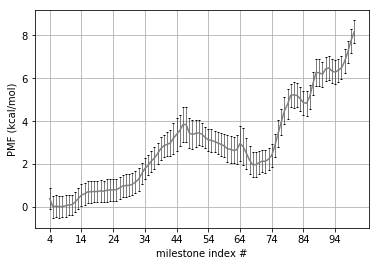

In [47]:
plt.figure()
plt.errorbar(
        range(b,f+1), 
        PMF_mfpt-PMF_mfpt.min(), 
        STD[b:f+1],
        color='gray', ecolor='k', elinewidth=0.5, capsize=1)
plt.grid()
plt.xlabel('milestone index #')
plt.ylabel('PMF (kcal/mol)')
plt.xticks(np.arange(b, f+1, step=10))
plt.show()

## 5.4 Calculate MFPT

In [48]:
print("MFPT from milestone %s to %s:"%(b, f))
mfpt = abs( (q_mfpt*MFPT_AVE[:,1][b:f+1]).sum()/q_mfpt[-1])/10**9
print("MFPT =\t %E ms" % mfpt)
count = np.array([1]*len(MFPT))
p_t_std = np.sqrt(((q_mfpt*MFPT_AVE[:,2][b:f+1])**2 / count[b:f+1]).sum())
std_mfpt = abs(p_t_std/q_mfpt[-1]/10**9)
print("std =\t %E ms" % std_mfpt)

MFPT from milestone 4 to 100:
MFPT =	 5.607809E-02 ms
std =	 1.006332E-02 ms


## 5.5 Calculate MFPT (stages)

In [88]:
res_time = np.array([[4, 16, 1.102278E-06],
                     [4, 46, 2.401908E-04],
                     [4, 80, 1.853582E-03],
                     [4, 88, 1.027926E-02],
                     [4, 100, 5.607809E-02]
                    ])
np.save(milestone_path+'/res_time.npy',res_time)

res_time = np.load(milestone_path+'/res_time.npy')

In [89]:
rt_txt=[]
for rt in enumerate(res_time):
    position = rt[1][1]
    tmp = rt[1][2]/10**3
    if tmp < 10**-9:
        tmp*=10**12
        tmp="%.2f ps"%tmp
    elif 10**-9 < tmp < 10**-6:
        tmp*=10**9
        tmp="%.2f ns"%tmp
    elif tmp>10**-6 and tmp<10**-3:
        tmp*=10**6
        tmp="%.2f \u03BCs"%tmp
    elif tmp>10**-3:
        tmp*=10**3
        tmp="%.2f ms"%tmp
    rt_txt.append([int(position),tmp])

In [97]:
STD.shape

(114,)

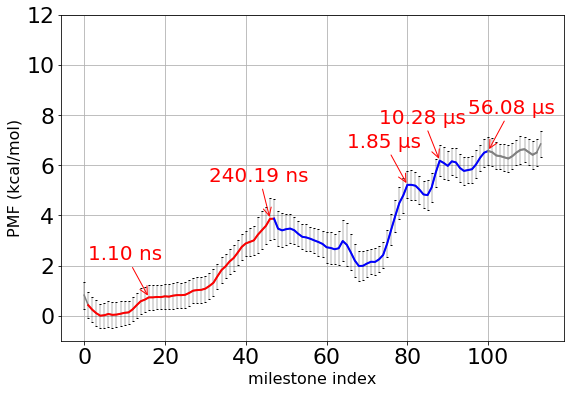

In [107]:
plt.figure(figsize=(9,6))
x = np.array(range(b,f+1))
y = (PMF_eigen - PMF_eigen.min())

bd1=47
bd2=100

plt.errorbar(
        x, 
        y, 
        STD,
        color='gray', ecolor='k', elinewidth=0.3, capsize=1)
plt.plot(x[1:bd1+1],y[1:bd1+1],color='red',linewidth=2,zorder=5)
plt.plot(x[bd1:bd2+1],y[bd1:bd2+1],color='b',linewidth=2,zorder=5)
plt.plot(x[bd2:-1],y[bd2:-1],color='gray',linewidth=2,zorder=5)
    
plt.grid()
plt.xlabel('milestone index',fontsize=16)
plt.ylabel('PMF (kcal/mol)', fontsize=16)
plt.xticks(np.arange(b,(f+1), step=20))

# for _,n in enumerate(txt):
#     plt.annotate(n[1], 
#                  (n[0], pmf[k]['f'][n[0]]-pmf[k]['f'].min()+0.3),**dict(size=10, color='b') )

ylim = y.max()-y.min()+3.5
for i,n in enumerate(rt_txt):
    x,y=[n[0], PMF_eigen[n[0]]-PMF_eigen.min()]
    if i==4:
        plt.annotate(n[1],xy=(x,y),
                     xytext=(x-5,y+1.5),
                    **dict(size=20,color='r'),arrowprops=dict(arrowstyle="->",color='r'))
    else:
        plt.annotate(n[1],xy=(x,y),
                     xytext=(x-15,y+1.5),
                    **dict(size=20,color='r'),arrowprops=dict(arrowstyle="->",color='r'))
    

plt.tick_params(labelsize=22)
plt.ylim([-1,12])
plt.savefig('/home/si_han/Desktop/uf/WeiChen/002_pmf_tau.pdf')
plt.show()

# 6. Compare initial-point distribution (IPD) and first hitting point distribution (FHPD) on milestones

## 6.1 Collect FHPD

In [40]:
# Collect FHPD on PC1/PC2 space
global_idx = []
for m in range(1, len(fp_mod)-1):
    index = TRANS[:,2] == m
    tmp = TRANS[index]
    idx = T*tmp[:,0]+tmp[:,4]
    global_idx.append(idx)
    
# Compute FHPD along the direction of the cooresponding milestone
FHPD = []
for m,i in enumerate(global_idx):
    dist_ = np.sqrt((PCA1[i]-Xn[m])**2 + (PCA2[i]-Yn[m])**2)
    FHPD.append(dist_)
FHPD = np.array(FHPD)

## 6.2 Collect IPD

In [41]:
# Collect IPD on PC1/PC2 space
global_idx2 = []
for m in range(1, len(fp_mod)-1):
    index = TRANS[:,1] == m
    tmp = TRANS[index]
    idx = T*tmp[:,0]+tmp[:,3]
    global_idx2.append(idx)
    
# Compute IPD along the direction of the cooresponding milestone
IPD=[]
for m,i in enumerate(global_idx2):
    dist_ = np.sqrt((PCA1[i]-Xn[m])**2 + (PCA2[i]-Yn[m])**2)
    IPD.append(dist_)
IPD.append(np.array(IPD))

## 6.3 Compare FHPD and IPD

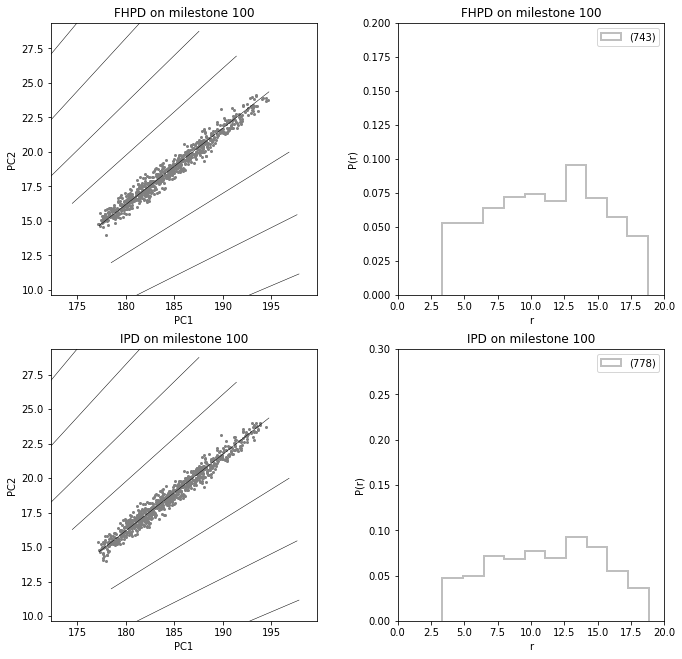

In [42]:
%matplotlib inline

m = 100 # targetting milestone
dv = 5 # visualization range in PC1/PC2 space, the smaller number gives more close-up view

#################################################################################################
######### Don Not Change Anything After This Line Unless You Know What You Are Doing ############
#################################################################################################

mp = m+1

fig=plt.figure(figsize=(11,11))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
x_,y_ = [[],[]]
for _,i in enumerate(global_idx[m]):
    x_.append(PCA1[i])
    y_.append(PCA2[i])
plt.plot(x_,y_,markersize='2',marker='o',c='gray',linestyle='None')
    
for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
plt.xlim([np.min([Xn[mp],Xp[mp]])-dv, np.max([Xn[mp],Xp[mp]])+dv])
plt.ylim([np.min([Yn[mp],Yp[mp]])-dv, np.max([Yn[mp],Yp[mp]])+dv])
plt.title('FHPD on milestone %d'%(m))
plt.xlabel('PC1')
plt.ylabel('PC2')


plt.subplot(2,2,2)
plt.hist(FHPD[m],bins=10,color='gray'
         ,alpha=0.5,density=True, fill=False, histtype='step', linewidth=2
         , label = '(%d)'%(len(FHPD[m])))
    
plt.title('FHPD on milestone %d'%(m))
plt.xlim([0,sc])
plt.ylim([0,0.2])
plt.xlabel('r')
plt.ylabel('P(r)')
plt.legend(loc=1)


plt.subplot(2,2,3)
x_,y_ = [[],[]]
for _,i in enumerate(global_idx2[m]):
    x_.append(PCA1[i])
    y_.append(PCA2[i])
plt.plot(x_,y_,markersize='2',marker='o',c='gray',linestyle='None')
    
for i in range(len(X)):
    if i==0:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],'-',
             color='black', linewidth=0.5,label='milestones')
    else:
        plt.plot([Xn[i,0], Xp[i,0]],[Yn[i,0], Yp[i,0]],
                 '-',color='black', linewidth=0.5)
plt.xlim([np.min([Xn[mp],Xp[mp]])-dv, np.max([Xn[mp],Xp[mp]])+dv])
plt.ylim([np.min([Yn[mp],Yp[mp]])-dv, np.max([Yn[mp],Yp[mp]])+dv])
plt.title('IPD on milestone %d'%(m))
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(2,2,4)
plt.hist(IPD[m],bins=10,color='gray'
         ,alpha=0.5,density=True, fill=False, histtype='step', linewidth=2
         , label = '(%d)'%(len(IPD[m])))
    
        
plt.title('IPD on milestone %d'%(m))
plt.xlim([0,sc])
plt.ylim([0,0.3])
plt.xlabel('r')
plt.ylabel('P(r)')
plt.legend(loc=1)

plt.show()

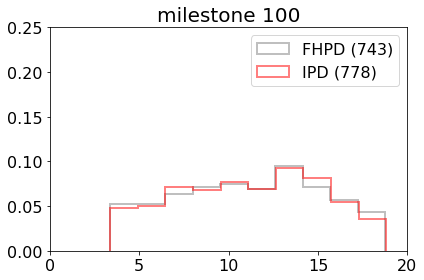

In [43]:
fig = plt.figure()
plt.hist(FHPD[m], bins=10, color='gray'
         ,alpha=0.5,density=True, fill=False, 
         histtype='step', linewidth=2, 
         label = 'FHPD (%d)'%(len(FHPD[m]))
        )
plt.hist(IPD[m], bins=10, color='r'
         ,alpha=0.5,density=True, fill=False, 
         histtype='step', linewidth=2, 
         label = 'IPD (%d)'%(len(IPD[m]))
        )
plt.title('milestone %d'%(m), fontsize=20)
plt.legend(loc=1,fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim([0,sc])
plt.ylim([0,0.25])
plt.tight_layout()

# 7. Generate a representative frame for each milestone

## 7.1 Nearest-to-average frame on each milestone
We define the representative frame as one of the initial-points of the milestone, whose position in the PC1/PC2 space has the shortest distance to the average position of all the entire IPD on the milestone. The index of the representative frame is stored in a list, Repre. 

The global index give an unique index for a specific frame from a specific replica of a specific initial configuration. The global index is defined as:<br/><br/>
$ID = id_1*(N_{replica}*N_{frame}) + id_2*(N_{frame}) + id_3 $, where

$ID$: global index <br/>
$id_1$: index of intial configuration, e.g. 0 for P0, 6000 for P6000<br/>
$id_2$: index of replica, e.g. 0 for 02.MD1, 15 for 02.MD16<br/>
$id_3$: index of frame in each short MD simulation <br/>
$N_{replica}$: total number of simulation replicas of each initial configuration <br/>
$N_{frame}$: total number of frames of each short MD simulation



In [44]:
Repre=[]
for m in range(len(fp)):
    x_,y_ = [[],[]]
    for _,i in enumerate(global_idx2[m]):
        x_.append(PCA1[i])
        y_.append(PCA2[i])

    x_, y_ = [np.array(x_),np.array(y_)]
    avx_,avy_ = [x_.mean(),y_.mean()]
    id_ = np.argmin( (x_ - avx_)**2 + (y_ - avy_)**2 )
    Repre.append(global_idx2[m][id_])
Repre = np.array(Repre)

## 7.2 Extract representative frames from short MD trajectories
If you used either Zhiye's or my bash script to submit short simulation jobs, the file structure should be P[0-6000]/02.MD[1-20], where 0-6000 and 1-20 could be dependent on the number of initial configurations and replica of simulations used. If you have different file structure, then you should modified the following script accordingly.

You should obtain a single *.dcd file, compiling all the representative frames following the order of milestones.

In [47]:
%mkdir {milestone_path+'/representative_frames'}

In [49]:
ShortMD_dir = '/hdd/si_han/ShortMD_tmp/WeiChen_VM2_candidates/002_C301-8809'# path of the folder containing all of the unwraped short MD trajectories
Repre_dir = milestone_path+'/representative_frames' # path of the folder you created to save representative frames

it = 0 # First index of the short MD simulation folder (e.g. it=0 for P0)
en = 1027 # Last index of the short MD simulation folder (e.g. it=6000 for P6000)
frq = 1 # frequencing of the folder index, e.g. frq=10 if your folders are P0, P10, ... P5990, P6000
iit = 1 # first replica in the above P* folder
ien = 10 # last replica  in the above P* folder

#################################################################################################
######### Don Not Change Anything After This Line Unless You Know What You Are Doing ############
#################################################################################################

id1 = np.floor(Repre/(T*ien))*frq # P{id1}
id2 = np.floor(Repre%(T*ien)/T)+1 #02.MD{id2}
id3 = Repre%(T*ien)%T #frame_indices=[id3]


filename=[]
for i in log_progress(range(len(id1))):
    filepath = ShortMD_dir+'/P'+str(int(id1[i]))+'/02.MD'+str(int(id2[i]))+'/MD1_unwrap.dcd'               
    mdtraj = pt.load(filepath, TOP, frame_indices=[id3[i]])

    pt.superpose(mdtraj, ref=refpdb, mask = mask)
    mdtraj.save(Repre_dir+'/m'+str(i)+'.dcd',overwrite=True)
    filename.append(Repre_dir+'/m'+str(i)+'.dcd')
    
movie = pt.iterload(filename,TOP)
pt.write_traj(Repre_dir+'/Repre_T%d_L%d.dcd'%(T,sc),movie,overwrite=True)

! rm {Repre_dir+'/'}m* # delete intermediate files

In [51]:
milestone_path+'/representative_frames'

'/hdd/si_han/Project/CDK8/metadynamics/WeiChen_VM2_candidates/002_C301-8809/100ns_seed6_restrt//Milestone_0/representative_frames'